## Set up environment paths

In [2]:
import setup
setup.main()
RAW_DIR, BINNED_DIR = setup.get_data_dir()

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
The raw data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viz
import neuralgeom.datasets.utils as utils
import neuralgeom.datasets.experimental as experimental
import os


INFO: Using pytorch backend


## Inspect Raw Data

In [4]:
expt_id = "34"

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

metadata = list(expt["x"].keys())
print(f"You can find metadata about:\n {metadata}.")

You can find metadata about:
 ['rat', 'day', 'epoch', 'type', 'finalGain', 'rosdata', 'clust', 'specGain'].


In [5]:
rat_id = expt["x"]["rat"]
print(f"The data was collected from rat {rat_id}.")

day = expt["x"]["day"]
print(f"The data was collected on day {day}.")

n_cells = len(expt["x"]["clust"])
print(f"There are {n_cells} neurons recorded in this experiment.")

epoch = expt["x"]["epoch"]
print(f"Epoch =  {epoch}")

final_gain = expt["x"]["finalGain"]
print(f"Final gain =  {final_gain}")

The data was collected from rat 637.
The data was collected on day 6.
There are 40 neurons recorded in this experiment.
Epoch =  m1
Final gain =  1


## Define experimental variables


- startTs: time in microseconds 

- stopTs: time in microseconds 

- encTimes: "encoder" times 

- encAngle: recorded angles of rat

- subepochs: "m1" exprrimental session, + periods where gain eitehr takes a different value or changes

- landAngle: angle of landmark frame

- gain: 

- vel: velocity of rat (degrees/s - close to cm/s here)

- relAngle: encAngle - landAngle

- landOffTime: when landmamarks turned off

- landOffAngle: encAngle(landOfftime) -- encAngle[landOffIdx]

- landOffIdx: index of lanfOffAngle

- estGain: gain estimated through Fourier analysis

- hippAngle: integral of G d$\theta$ angle of rat in estimated hippocampal frame

## Load neural activity + measured lab variables ("labels")

This section walks through the processing of the experimental data to obtain neural activity vectors and corresponding laboratory measurements. 
The result is identical to the ouput of `neuralgeom.datasets.experimental.load_neural_activity` used in the following section

**Set velocity threshold (in degrees/second)**

In [6]:
velocity_threshold = 5

**Find all contigious periods where velocity > threshold** : 
Each element of `period_start_times` and `period_end_times` is a time in `exp["x"]["rosdata"]["encTimes"]` where a contiguous period with velocity > threshold starts and ends, respectively

Mean rise length: 0.8449574409793814 seconds
Median rise length: 0.42016875 seconds
Total number of rise events: 970


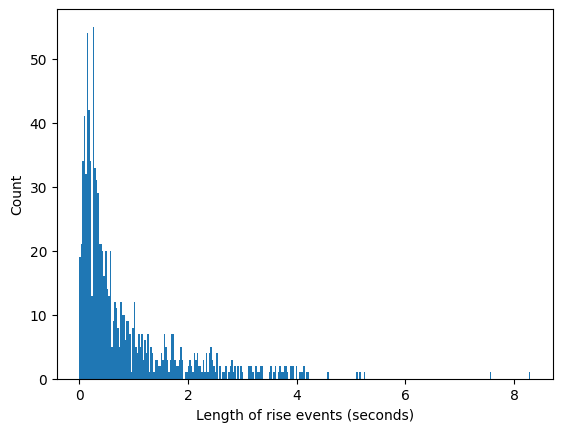

In [7]:
period_start_times, period_end_times, df = experimental._apply_velocity_threshold(expt, threshold=velocity_threshold)

**Set binning timestep (in microseconds)**

In [8]:
timestep_microseconds = int(1e5)

**Find bin edges (`sampling_times`) for all valid bins (all bins in every period where velocity > threshold)**

In [9]:
sampling_times = experimental._get_sampling_times(period_start_times, period_end_times, timestep_microseconds)

print(f"There are {len(sampling_times)} valid time periods of duration AT LEAST {timestep_microseconds} microseconds")

There are 891 valid time periods of duration AT LEAST 100000 microseconds


**Visualize thresholded sampling**

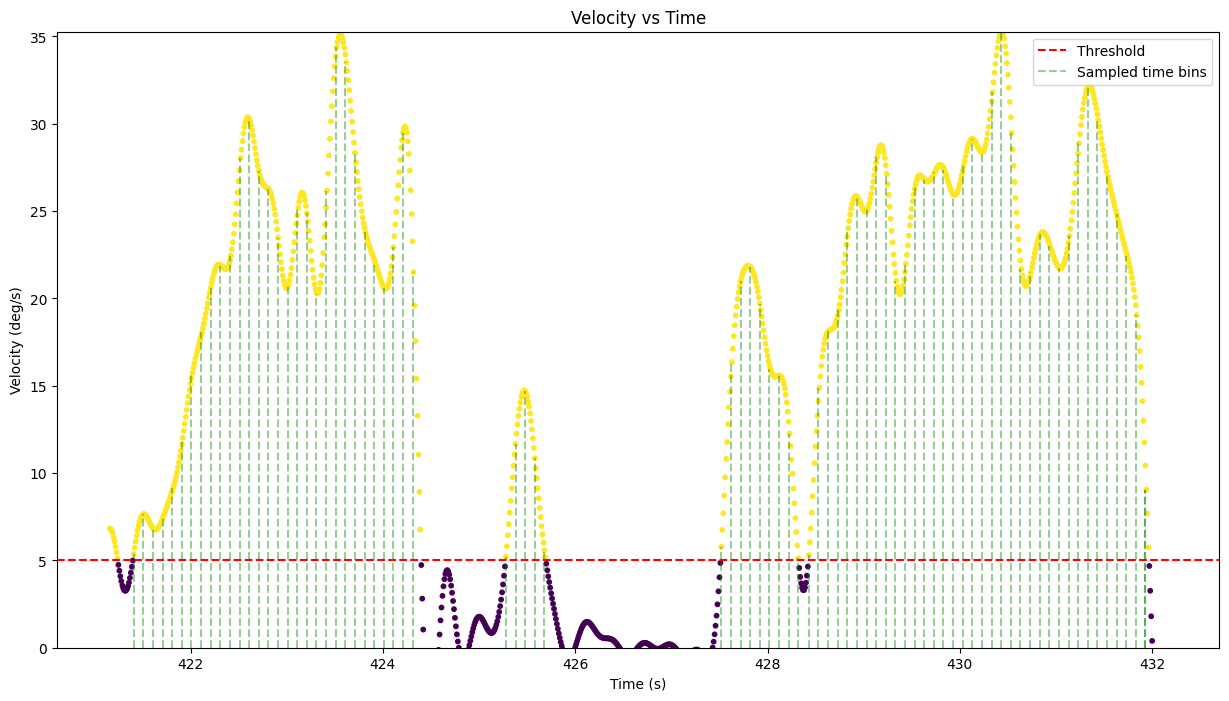

In [10]:
fig = plt.figure(figsize=(15, 8))

i_start = 6000
i_end = 7100

times_secs = df['encTimes'][i_start:i_end]*1e-6
velocities = df['vel'][i_start:i_end]
colors = df['above_threshold'][i_start:i_end]


plt.scatter(times_secs, velocities, c=colors, cmap='viridis',s=10)
plt.axhline(y=5, color='r', linestyle='--',label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (deg/s)')
plt.title('Velocity vs Time')
plt.ylim(0, velocities.max())


for period in sampling_times[10:14]:
    for time in period:
        ymax = df["vel"][np.searchsorted(df["encTimes"],time)]/velocities.max()
        plt.axvline(x=time*1e-6, ymax = ymax, color='green', linestyle='dashed',alpha=0.4)

plt.axvline(x=time*1e-6, ymax = ymax, color='green', linestyle=('dashed'),label='Sampled time bins',alpha=0.4)



plt.legend();

**Get the neural activity**

In [11]:
neural_activity = []

for neuron_index, neuron in enumerate(expt["x"]["clust"]):
    neuron_i_activity = []
    for times in sampling_times:
        spike_count, _ = np.histogram(neuron["ts"], bins=times)
        neuron_i_activity.extend(spike_count)
            
    neural_activity.append(neuron_i_activity)

neural_activity = np.array(neural_activity).T


print(f"There are {neural_activity.shape[0]} data points of neural activity for this experiment.")


There are 7801 data points of neural activity for this experiment.


**Get values of laboratory variables, i.e., "labels"**

In [14]:
recorded_angles = expt["x"]["rosdata"]["encAngle"]
recorded_times = expt["x"]["rosdata"]["encTimes"]
recorded_vel = expt["x"]["rosdata"]["vel"]
recorded_gain = expt["x"]["rosdata"]["gain"]

angles = experimental._average_variable(recorded_angles, recorded_times, sampling_times)
lap = angles//360
angles = angles % 360
all_times = experimental._average_variable(recorded_times, recorded_times, sampling_times)
velocities = experimental._average_variable(recorded_vel, recorded_times, sampling_times)
gains = experimental._average_variable(recorded_gain, recorded_times, sampling_times)


labels = pd.DataFrame(
    {
        "times": all_times,
        "lap": lap,
        "angles": angles,
        "velocities": velocities,
        "gains": gains,
    }
)

## Load neural activity & labels
Using `neuralgeom.datasets.experimental.load_neural_activity`

In [15]:
import neuralgeom.datasets.experimental as experimental

expt_id = "34"
timestep_microsec = int(1e5)
vel_threshold = 5

neural_activity, labels = experimental.load_neural_activity(expt_id=expt_id, vel_threshold= vel_threshold, timestep_microsec=timestep_microsec)

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

print(f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps")

INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_times_timestep100000_velthreshold_5.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_neural_activity_timestep100000_velthreshold_5.npy! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep100000_velthreshold_5.txt! Loading...


There are 40 neurons binned over 7801 timesteps


Visualize activity over time (PSTH) -- no speed thresholding

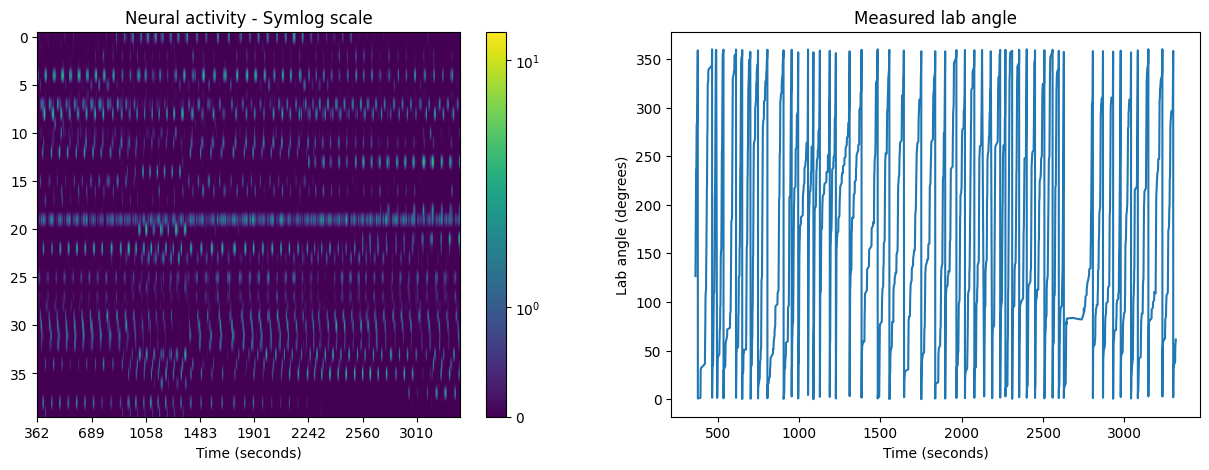

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

psth = axs[0].imshow(neural_activity.T, aspect="auto",cmap="viridis",norm="symlog")
axs[0].set_title("Neural activity - Symlog scale")
axs[0].set_xticks(np.arange(len(times_in_seconds))[::1000])
axs[0].set_xticklabels(times_in_seconds[::1000].astype(int))
axs[0].set_xlabel("Time (seconds)")

fig.colorbar(psth,ax=axs[0])

axs[1].plot(times_in_seconds, angles)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Lab angle (degrees)")
axs[1].set_title("Measured lab angle");

## Calculate Mutual Information between angular position and activity for each neuron

!!!!!TODO!!!!!: 

Look for existing implementation of multivariate mutual information

For now: account for topology of task by definining mutual information between position $\theta$ and neural activity $r_i$ of neuron $i$ as:

$$ \text{MI}(r_i,\theta) \equiv \text{MI}(r_i,\cos{\theta}) + \text{MI}(r_i,\sin{\theta}) $$


What are other tests of independence/ correlation coefficiens?

See:
- https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
- https://arxiv.org/pdf/1307.7383.pdf
- https://arxiv.org/pdf/1909.10140.pdf
- https://github.com/minepy/mictools

In [20]:
from sklearn.feature_selection import mutual_info_regression
angles_radians = angles*np.pi/180

X = np.cos(angles_radians)
Y = np.sin(angles_radians)

spatial_mutual_info_X = mutual_info_regression(neural_activity,X)
spatial_mutual_info_Y = mutual_info_regression(neural_activity,Y)
spatial_mutual_info_XY = spatial_mutual_info_X + spatial_mutual_info_Y

**Visualize peristimulus angle histogram (PSAH) with individual spatial mutual information score**

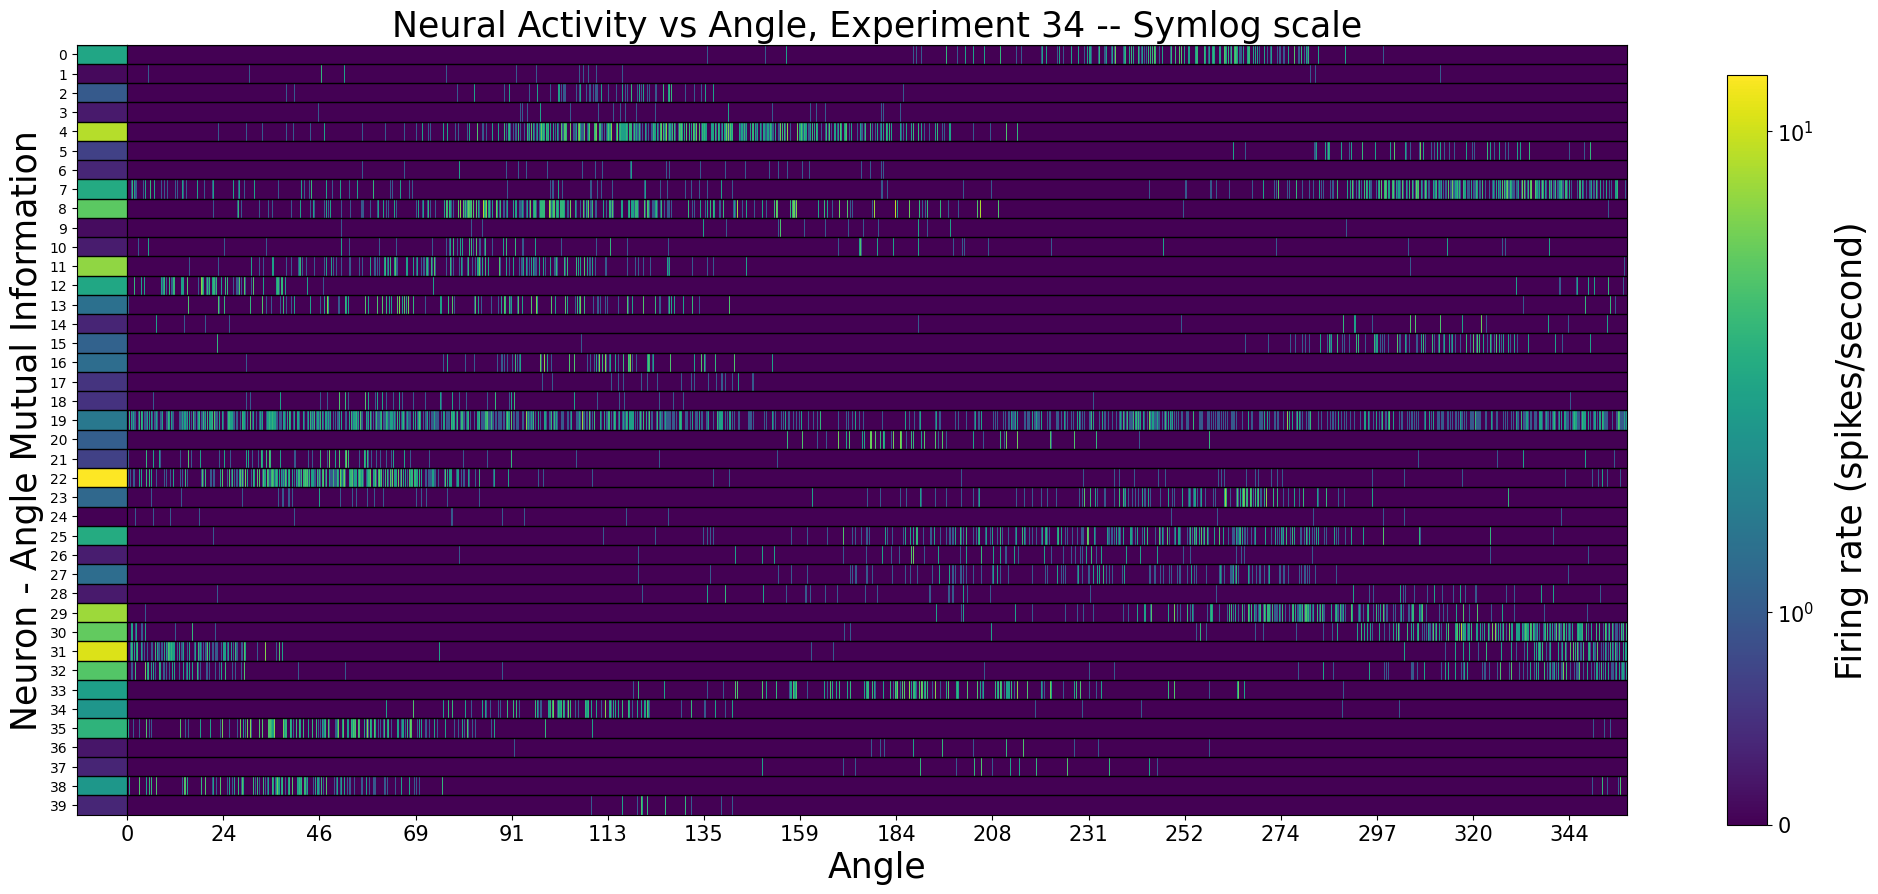

In [22]:
import viz

sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=sorted_neural_activity,task_variable=sorted_angles,mutual_info=spatial_mutual_info_XY)

Set Spatial Mutual Information threshold

there are 16 neurons with spatial information above 0.1


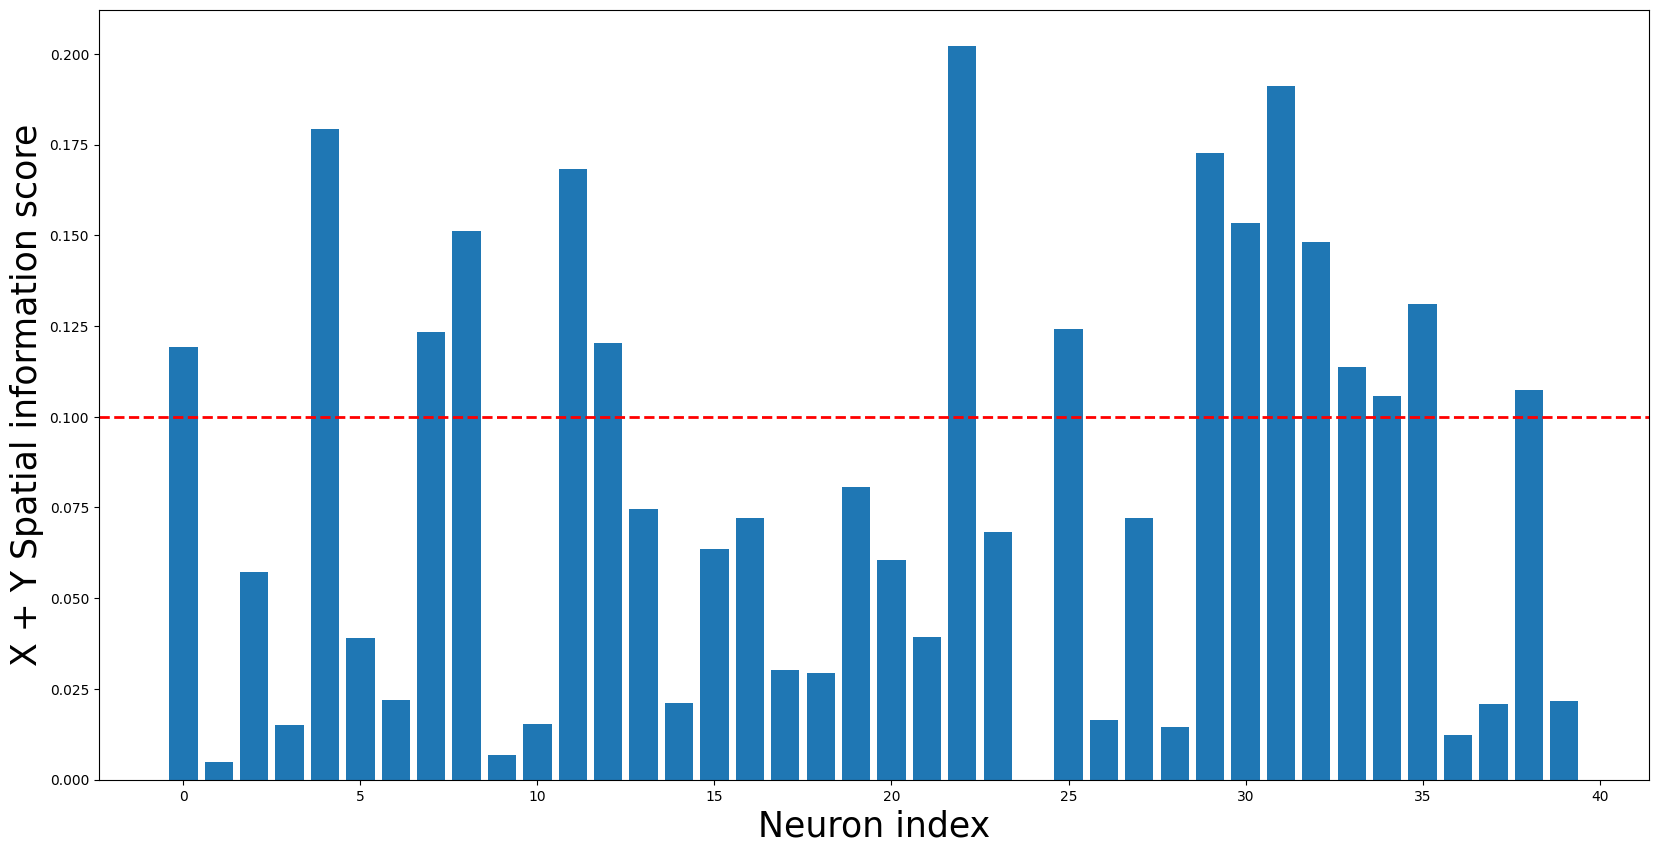

In [23]:
mi_threshold = 0.1

mi_thresh_neural_activity = neural_activity[:,spatial_mutual_info_XY>mi_threshold]
mi_thresh_spatial_mutual_info = spatial_mutual_info_XY[spatial_mutual_info_XY>mi_threshold]

x_ticks = np.arange(0,len(spatial_mutual_info_XY))

fig, axs = plt.subplots(figsize=(20,10))

axs.bar(x_ticks, spatial_mutual_info_XY)
axs.set_xlabel("Neuron index",fontsize=25)
axs.set_ylabel("X + Y Spatial information score",fontsize=25)
axs.axhline(mi_threshold, color='red', lw=2, linestyle='--',label="MI threshold");

print(f"there are {len(mi_thresh_spatial_mutual_info)} neurons with spatial information above {mi_threshold}")

### Visualize high MI neurons, organized by place field centers

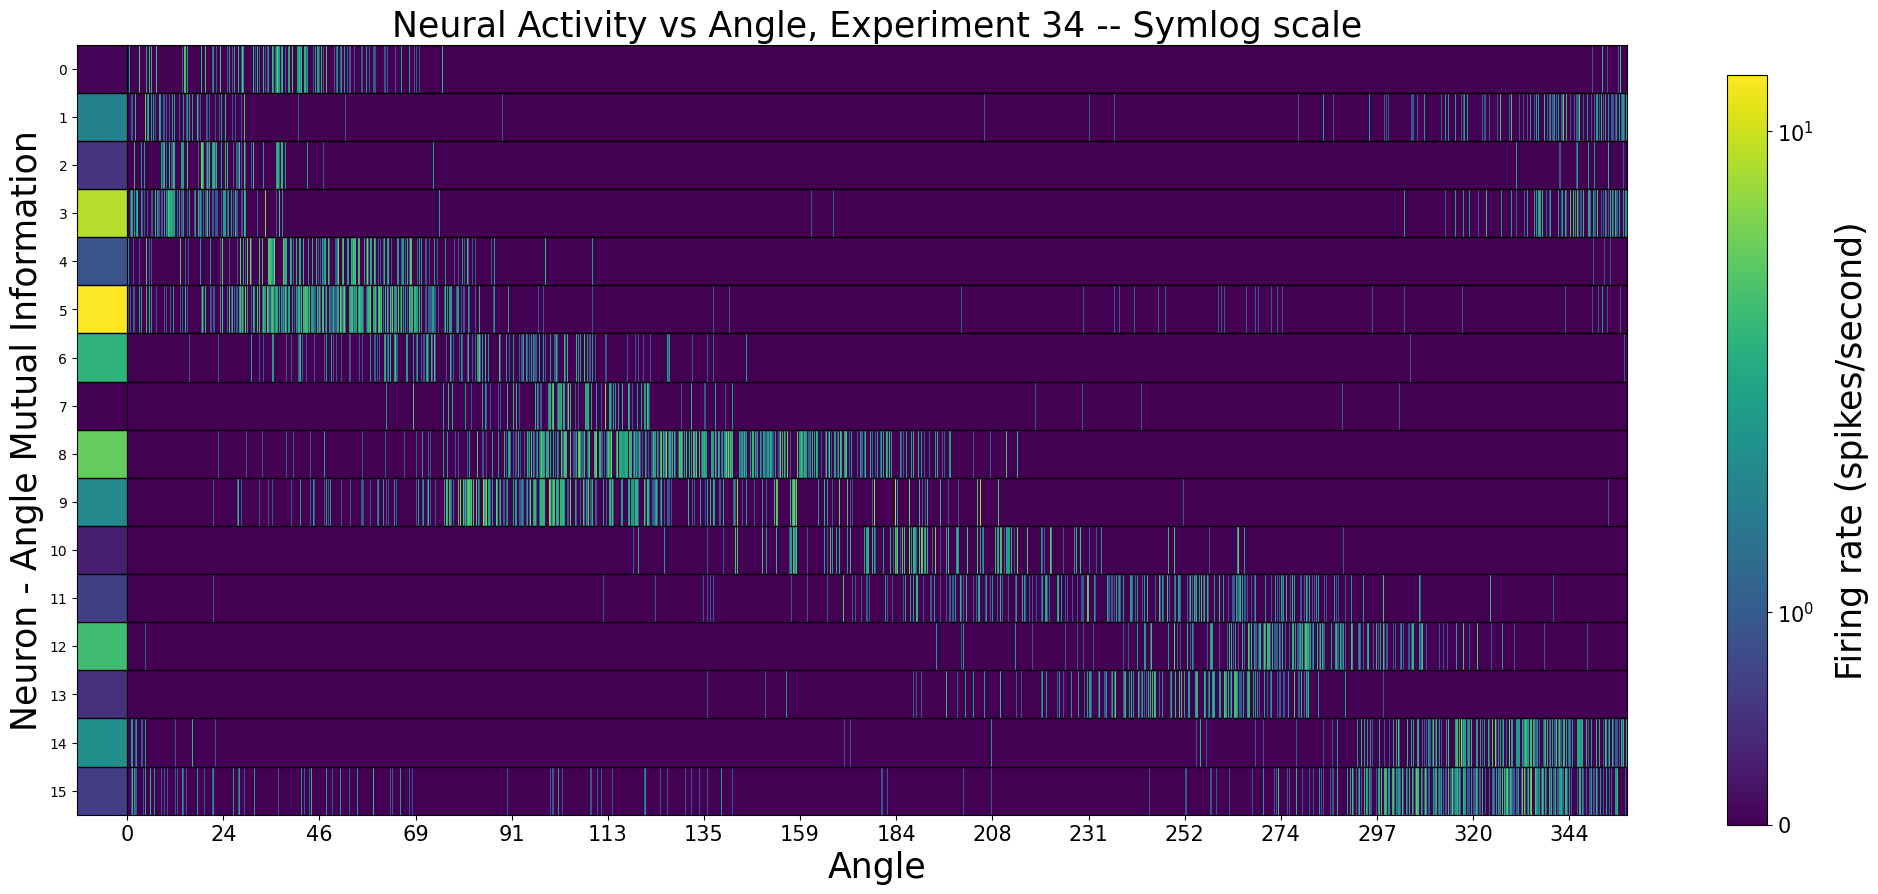

In [24]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

center_of_mass, center_of_mass_indices = experimental.get_place_field_centers(sorted_mi_thresh_neural_activity, sorted_angles)
com_sort = np.argsort(center_of_mass_indices)

organized_neural_activity = sorted_mi_thresh_neural_activity[:,com_sort]
organized_spatial_mutual_info = mi_thresh_spatial_mutual_info[com_sort]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=organized_neural_activity,task_variable=sorted_angles,mutual_info=organized_spatial_mutual_info)

In [26]:
organized_neural_activity.shape

(7801, 16)

**Visualize 3D projection of neural state space (3 neurons with adjacent place fields)**

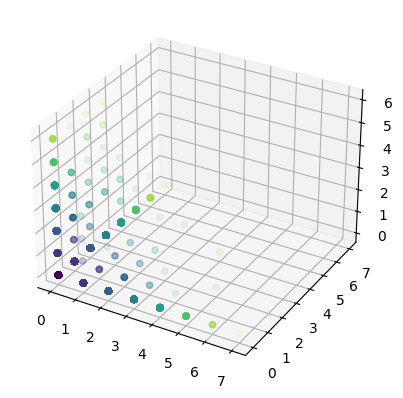

In [43]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

neuron_x_id = 5
neuron_y_id = 8
neuron_z_id = 10


x = organized_neural_activity[:,neuron_x_id]
y = organized_neural_activity[:,neuron_y_id]
z = organized_neural_activity[:,neuron_z_id]

radius = np.sqrt(x**2 + y**2 + z**2)

ax.scatter(x,y,z,alpha=0.1,c=radius ,cmap="viridis");

## Run PCA

Find the eigenspectrum. How does it decay? --> Is the neural manifold "Smooth"?

See: https://www.nature.com/articles/s41586-019-1346-5

## Train Decoder FFNN

In [ ]:
neural_activity.shape

(7801, 40)

In [ ]:
# copy archtecture from VAE encoder

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set a fixed random seed for reproducibility
torch.manual_seed(0)


input_dim = neural_activity.shape[1]

# Define a simple feedforward neural network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50).float()  # First hidden layer
        self.fc2 = nn.Linear(50, 20).float()  # Second hidden layer
        self.fc3 = nn.Linear(20, 2).float()  # Output layer

    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = F.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = self.fc3(x)  # No activation function after final layer (for regression task)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [ ]:
# Create an instance of the network
decoder = Decoder().to(device)

# Use mean squared error loss for regression
criterion = nn.MSELoss()

# use adam optimizer
optimizer = optim.Adam(decoder.parameters(), lr=0.01)

In [ ]:
cos_sin_angles = np.vstack((np.cos(angles_radians),np.sin(angles_radians))).T

In [ ]:
# Assume we have some training data in input_data (100-dimensional input) and target_data (2-dimensional output)
input_data = torch.from_numpy(neural_activity).float().to(device)
target_data = torch.from_numpy(cos_sin_angles).float().to(device)

# Split data into training and validation sets (80-20 split)
train_size = int(0.8 * len(input_data))
val_size = len(input_data) - train_size

train_data = TensorDataset(input_data[:train_size], target_data[:train_size])
val_data = TensorDataset(input_data[train_size:], target_data[train_size:])

# Create DataLoaders from your datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

In [ ]:
# Arrays to keep track of losses
train_losses = []
val_losses = []


# Train the network
for epoch in range(10):  # Loop over the dataset multiple times
    # Training phase
    decoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoder(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss}")

    # Validation phase
    decoder.eval()
    with torch.no_grad():
        running_loss = 0.0
        for inputs, targets in val_loader:
            outputs = decoder(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

        epoch_loss = running_loss / len(val_loader)
        val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}")

print('Finished Training')

Epoch 1, Training Loss: 0.3142315571506818
Epoch 1, Validation Loss: 0.29424671332041424
Epoch 2, Training Loss: 0.24176383018493652
Epoch 2, Validation Loss: 0.3811403214931488
Epoch 3, Training Loss: 0.2210537133117517
Epoch 3, Validation Loss: 0.3070708016554515
Epoch 4, Training Loss: 0.20854043836394945
Epoch 4, Validation Loss: 0.3000430365403493
Epoch 5, Training Loss: 0.19846517716844878
Epoch 5, Validation Loss: 0.3057163457075755
Epoch 6, Training Loss: 0.1862193395694097
Epoch 6, Validation Loss: 0.346140056848526
Epoch 7, Training Loss: 0.17637136081854501
Epoch 7, Validation Loss: 0.33300142486890155
Epoch 8, Training Loss: 0.17085030302405357
Epoch 8, Validation Loss: 0.337270845969518
Epoch 9, Training Loss: 0.16066106408834457
Epoch 9, Validation Loss: 0.38175397117932636
Epoch 10, Training Loss: 0.1577532465259234
Epoch 10, Validation Loss: 0.33619343241055805
Finished Training


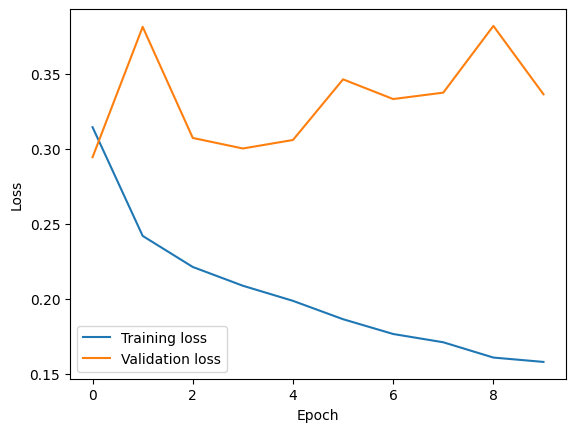

In [ ]:
# Plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()